<center><font size = "10"> Week 3 - Ion Channels <center>
<center><font size = "8">Home work<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 1
<br>Group member1: Gasser Elbanna
<br>Group member2: Milo Imbeni
<br>Group member3: Louise Placidet

In [2]:
# Importing libraries:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import h5py
from neuron import h

# Ex1. Fit data to sigmoid curve

<font size = "3">Fit the data in Sigmoid.dat file located in your group folder. 

<font size = "3">The function of a sigmoid is:
\begin{equation}  
    y = \frac {1}{(1 + e^{(\frac{x - vh}{-slope})})}
\end{equation}
    
<font size = "3">Show the data and the fitted curve on the same plot (as it was done in tutorial 1), label the axes and create a legend to differentiate the data from the fitted curve. Evaluate how well the curve fits the data. [0.5 pts]

In [3]:
def func_sig(x, v_half, slope):
    return 1/(1 + np.exp(-(x-v_half)/slope))

def curveFittingSingleSigmoid(fileName):
    '''This function computes an sigmoid fitting for the data in fileName'''
    # Open the file and separate the columns in x and y
    df = pd.read_table(fileName, sep='\s+', header=None)
    x_data = df[0]
    y_data = df[1]
    
    # In this case, we want to compute v_half = popt[0] and slope = popt[1]
    # and to quantify the fitting quality we want to know perr
    popt, pcov = curve_fit(func_sig, x_data, y_data)
    perr = np.sqrt(np.diag(pcov))
        
    plt.figure(figsize=(10,6))
    print('Error for: ')
    print('V_half error: %.3f'%(perr[0]))
    print('Slope error: %.3f'%(perr[1]))
    plt.plot(x_data, y_data, 'xk', label='original data' )
    plt.plot(x_data, func_sig(x_data, popt[0], popt[1]), '-r',label='fit data: with v_half=%.3f, slope=%.3f' %(popt[0], popt[1]))
    plt.xlabel('Voltage V [mV]')
    plt.ylabel('G/G_max: normalized conductance')
    plt.legend()
    plt.show()

Error for: 
V_half error: 0.128
Slope error: 0.114


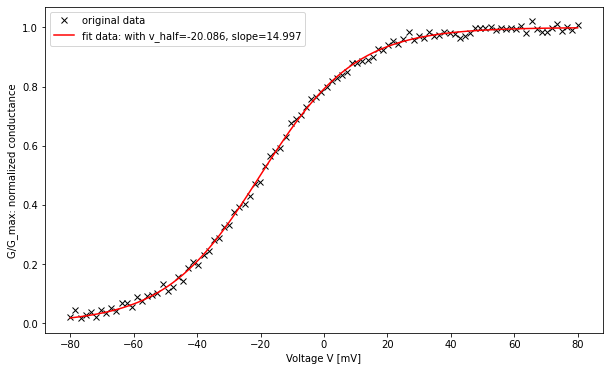

In [4]:
dat_path = 'Group 1/Sigmoid.dat'

curveFittingSingleSigmoid(dat_path)

Using the scipy function curve_fit, we are able to compute the estimated covariance of the fitting.  This enables us to then obtain the standard deviation error for our respective parameters, slope and v_half.  In this case, the errors computed for the slope and v_half are respectively 0.128 and 0.114.

As a result, we have:

v_half = -20.086 +/- 0.128 mV
slope = 14.997 +/- 0.114

# Ex2. Analysing an activation curve.

<font size = "3">Using the .NWB file in your folder group, fit each of the traces between 100 ms and the maximum amplitude of the trace to an exponential, to find the time constant at every voltage step. What does this time constant represent ? Plot the time constants for the activation, considering that the clamped voltage stimulation is between -90 and +80 mV with a 10mV step interval. [2 pts]


In [5]:
def func_exp(x, a, b, tau):
    return a - b*(1-np.exp(-x/tau))

In [6]:
def analyse_activation_curve(nwbFile, protocolName, repID, plotTraces = False):
    ''' Function .....
    :param nwbFile: the data path to file
    :param protocolName: protocol name defined in the data file
    :param repID: protocol repetition number
    :param byTraces: if true, represent each trace in one figure'''
    
    # Open the file
    open_data = h5py.File(nwbFile, 'r')
    
    # Select on strings what do we want for ploting
    string_data = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/data'
    string_xinterval = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/x_interval'
    string_xstart = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/x_start'
    
    # safe on different variables
    data = open_data[(string_data)][()]
    x_interval = open_data[(string_xinterval)][()]
    x_start = open_data[(string_xstart)][()]
    
    # create time vector in ms
    nRow, nCol = data.shape
    x_end = x_start[0] + x_interval[0]*(float(nRow - 1))
    time = np.linspace(x_start[0], x_end, nRow)*1000
    
    
    data_t = np.transpose(data)
    i = 0
    
    # For each trace,the tau values is computed as well as the standard deviation
    tau_values = [] # the tau values computed for each trace
    tau_sd = [] # the standard deviation for each of the tau values obtained
    
    fig = plt.figure(figsize=(20, 50))

        
    for trace in data_t:
        # First limit the data and time interval for it to start at 100ms
        time_reduced = time[time >= 100]
        trace_reduced = trace[np.where(time == 100)[0][0]:]
        
        # For each trace, the data and time intervals are limited to the maximum value of the amplitude of the trace
        time_of_max = time_reduced[np.argmax(trace_reduced)] # time where the amplitude of the trace is maximum
        time_reduced_twice = time_reduced[:np.argmax(trace_reduced)+1] # keeping only the time interval before the amplitude max
        trace_reduced_twice = trace_reduced[:np.argmax(trace_reduced)+1] # keeping the trace until it reaches its maximum
        time_reduced_twice = (time_reduced_twice - 100);
        
        # Fitting exponential curve to it
        popt, pcov = curve_fit(func_exp, time_reduced_twice, trace_reduced_twice)
        perr = np.sqrt(np.diag(pcov)) # standard deviation
        
        
        # Adding tau and standard deviation of tau in lists:
        tau = popt[2]*np.max(time_reduced_twice)
        tau_values.append(tau)
        
        if plotTraces:
            # Plotting to check
            axes = fig.add_subplot(9, 2, i+1)
            axes.set_title('%s protocol, trace %s' %(protocolName,i))
            axes.set_ylabel('Current traces [nA]')
            axes.set_xlabel('time [ms]')
            axes.scatter(time_reduced_twice, trace_reduced_twice)
            axes.plot(time_reduced_twice, func_exp(time_reduced_twice, popt[0], popt[1], popt[2]), '-r',label='fit: tau=%.3f' %(popt[2]))
            plt.legend()
            i = i + 1
    
    
    #fig2 = plt.figure(figsize = (10,8))
    #voltage_range = np.arange(start=-90, stop=90, step=10)
    #plt.plot(voltage_range, tau_values)
    #plt.title('Tau values according to voltage')
    #plt.xlabel('Voltages [mV]')
    #plt.ylabel('Tau values [ms]')
    #plt.grid(True)
    
    fig3 = plt.figure(figsize = (10,8))
    voltage_range = np.arange(start=-20, stop=90, step=10)
    plt.plot(voltage_range, tau_values[7:])
    plt.title('Tau values according to voltage, starting at v = -20mV')
    plt.xlabel('Voltages [mV]')
    plt.ylabel('Tau values [ms]')
    plt.grid(True)

From the plot above, we plotted the time constant according to the injected voltage.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parame

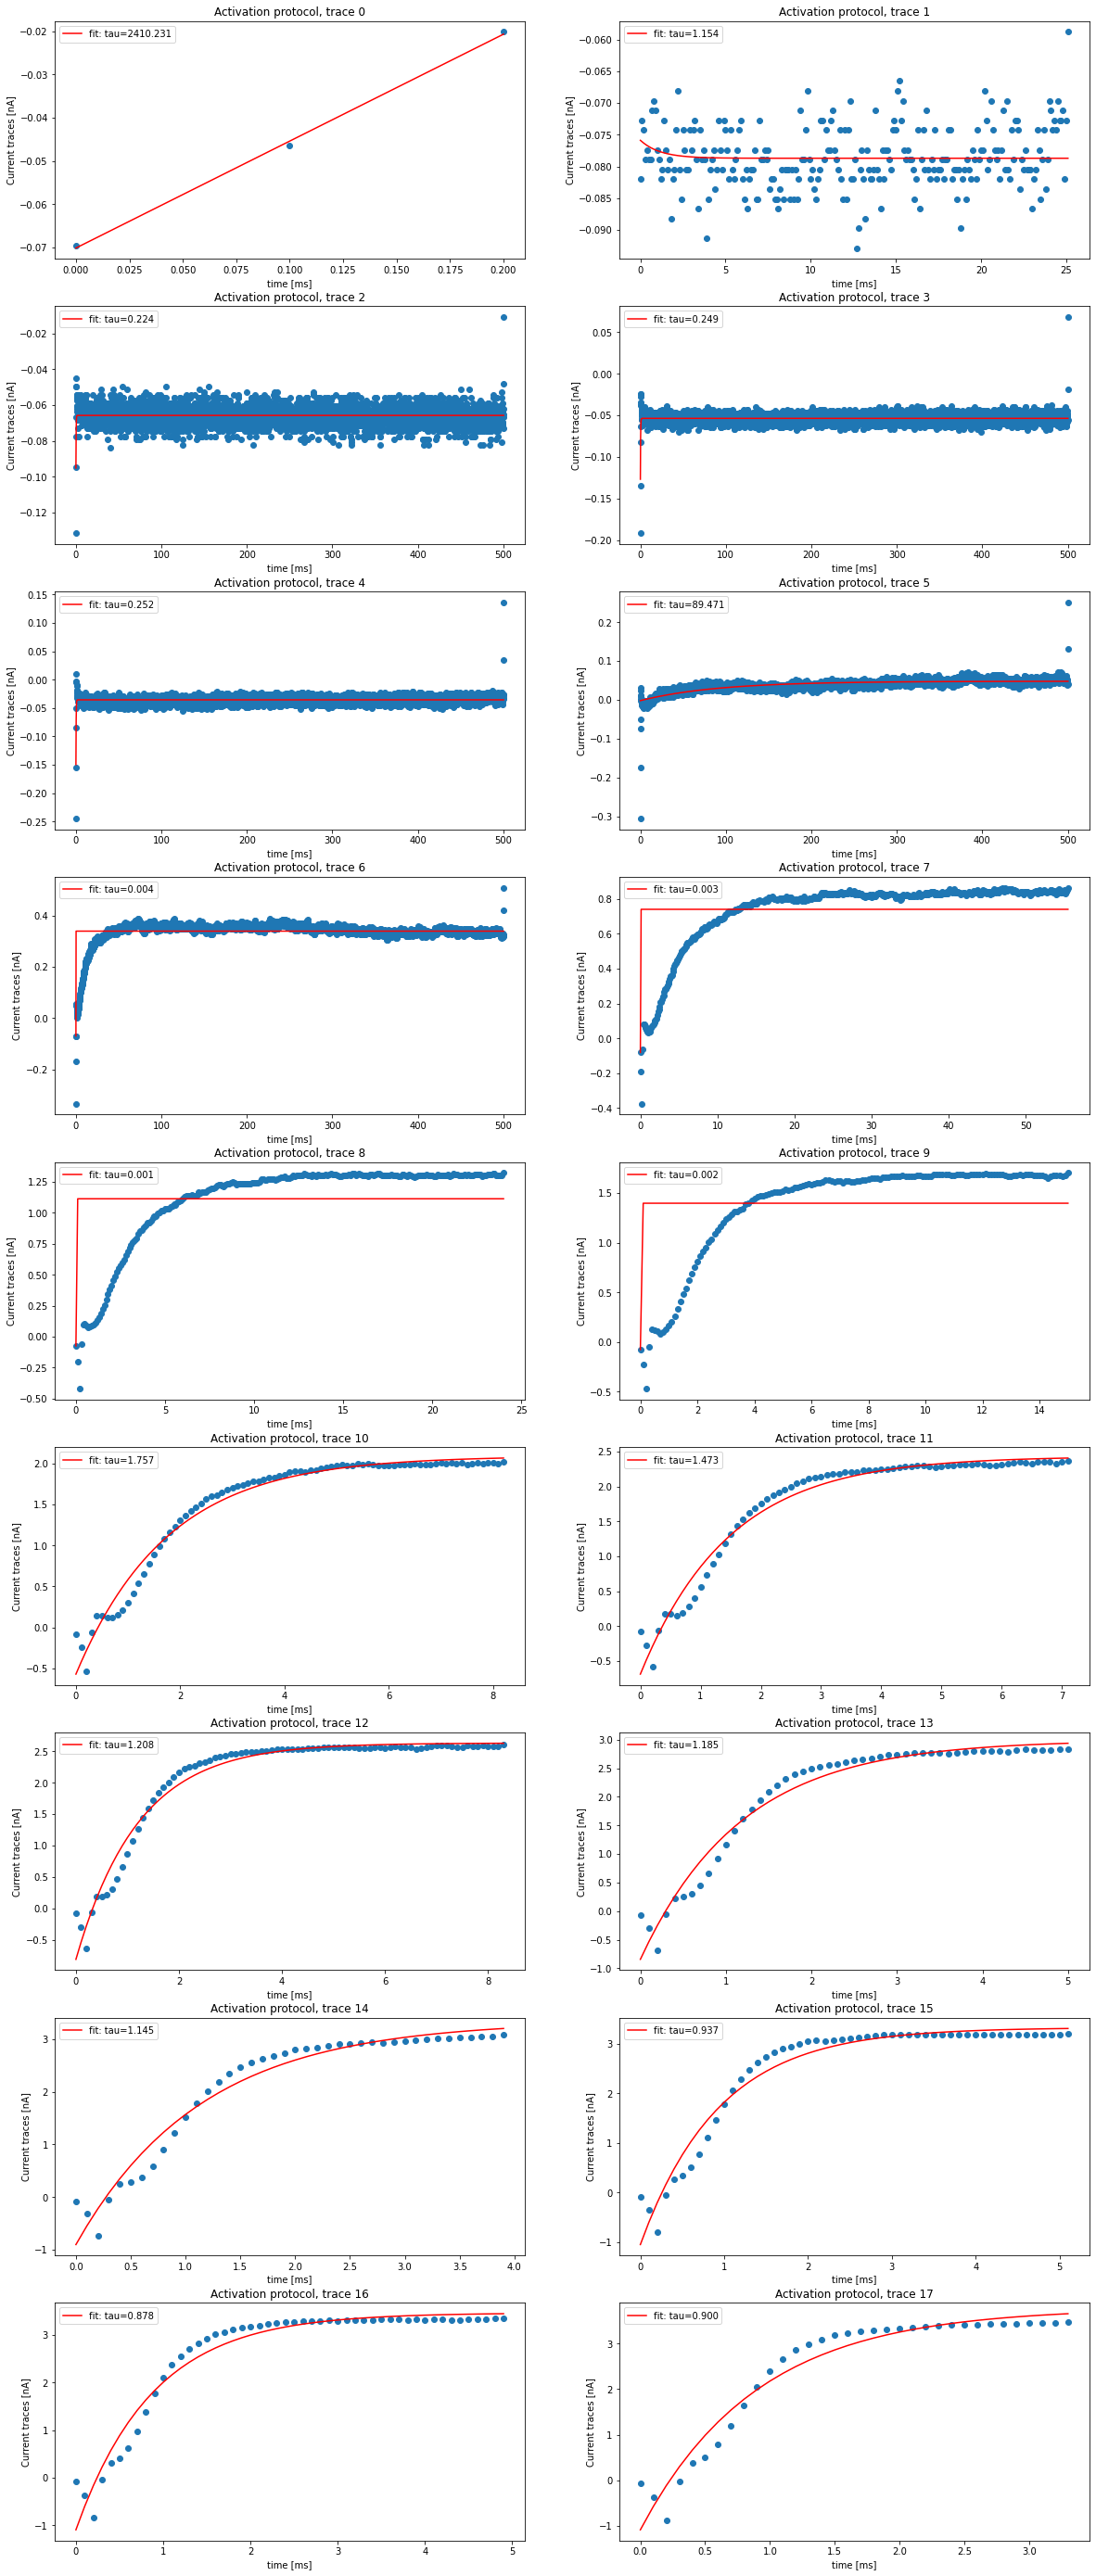

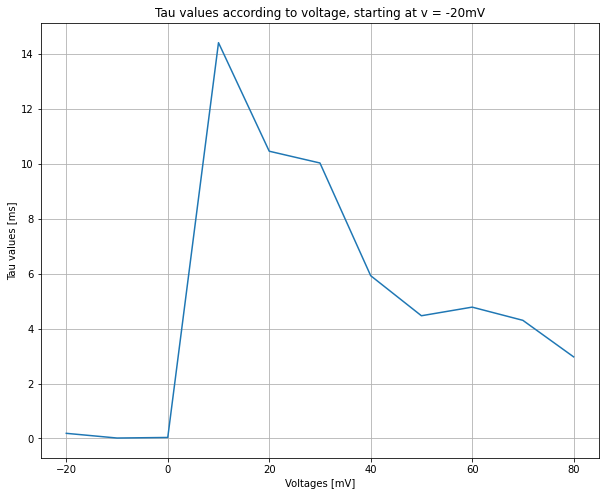

In [7]:
data_path = 'rCell2268.nwb'

analyse_activation_curve(data_path, 'Activation', '2', plotTraces=True)

### Discussion:

When plotting the tau values according to the voltages, we are limiting ourselves to -20 mV.  Indeed, before that, the tau values obtained are relatively important.  This comes from the fact that the current traces are very flat, and as a result, fitting an exponential curve to it means that the time constant to reach the maximum value is high.

The time constant corresponds to the time that the membrane takes to charge up.  It is expressed as:
$$\tau = R*C$$
Where R and C are respectively, the membrane resistance and the membrane capacitance.

On the graphics, tau can be read as the time that the curernt takes to reach 63% of its maximum value.

# Ex3. Find the minimum current amplitude to make the cell fire

<font size = "3">Create a cell in Neuron with the fillowing characteristics: 1 section (soma) with one segment, 15 µm of length and diameter, 120 Ω*cm of axial radius and 1.6 µF/cm^2 of capacitance. Add passive and active (gNa = 0.1 S and gK = 0.015 S) membrane properties to this cell. Generate a current clamp experiment in which you will inject a current into the cell soma with 50 ms delay, 500 ms of duration. The total recording duration of the experiment would be 800 ms and the voltage base -70 mV. Find the minimum amount of current that has to be injected in this cell in order to make it fire (an automated way of finding this value is an option). What is the threshold membrane voltage? How do the rheobase and theshold voltage change when the membrane properties are changed?
    
<font size = "3">Keep in mind that square current pulses are not biologically realistic. Discuss why finding the minimum amount of current that makes a neuron fire could be interesting to study the cell. [1 pt]

In [8]:
# Create a section 

def create_cell(Ra, c, gna, gk):
    soma = h.Section()
    soma.L = 15.0     # length (µm)
    soma.diam = 15.0  # diameter (µm)
    soma.Ra = Ra    # axial resistivity (Ω*cm)
    soma.cm = c     # capacitance (µF/cm^2) 

    # Insert passive properties
    soma.insert('pas')
    for seg in soma:
        seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
        seg.pas.e = -70   # Leak reversal potential, it influences the steady state membrane potential

    # Insert active properties
    soma.insert('hh')
    for seg in soma:
        seg.hh.gkbar = gk # Maximal conductance of the potassium channels
        seg.hh.gnabar = gna  # Maximal conductance of the sodium channels
    return soma

In [9]:
def simulation_protocol(soma):
    stim = h.IClamp(soma(0.5))         # Place a stimulation electrode in the middle of the soma
    stim.delay = 50   # stim delay (ms)
    stim.dur = 500     # stim duration (ms)

    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)

    # membrame potential vector
    rec_v = h.Vector()
    rec_v.record(soma(0.5)._ref_v)
    return stim, rec_v, rec_t

In [10]:
def APs_peaks(MembanePotential, thr):
    """
    In this function we compute the number of spikes from the voltage recordings and their heights (Not needed)
    """
    ap_peak_ind, ap_peak = find_peaks(MembanePotential, height=thr) # find position of AP
    
    return ap_peak_ind, ap_peak['peak_heights']

In [11]:
def AP_threshold(membrane_potential, sr_vm, ap_peak_index, ap_peak_vm, vm_deriv_thrs):
    """
    In this function we find the action potential threshold.
    We define the threshold as the point where the derivative is the maximum before the AP.
    """
    vm_deriv = np.diff(membrane_potential) * 0.001 * sr_vm # we calculate the derivative
    # we find the points that have derivative
    ap_thr_onset = np.diff((vm_deriv - vm_deriv_thrs) / np.abs(vm_deriv - vm_deriv_thrs))

    # initialize arrays 
    ap_thrs_ind = np.empty_like(ap_peak_vm)
    ap_thrs_vm = np.empty_like(ap_peak_vm)

    time_search = int(0.002 * sr_vm)
    for i, ap_ind in enumerate(ap_peak_index):
        peak_ind = ap_ind
        before_peak_ind = peak_ind - time_search
        after_peak_ind = peak_ind + time_search
        
        # we need a sanity check first that we don't go over the threshold of the array
        if before_peak_ind > 0 and after_peak_ind < membrane_potential.shape[0]:
            ind = np.argmax(ap_thr_onset[before_peak_ind:after_peak_ind])
            ap_thrs_ind[i] = before_peak_ind + ind 
            ap_thrs_vm[i] = membrane_potential[int(ap_thrs_ind[i])]
            
        else:
            ap_thrs_ind[i] = np.nan
            ap_thrs_vm[i] = np.nan
            
    return ap_thrs_ind, ap_thrs_vm, vm_deriv

In [12]:
def compute_rheobase(soma_v_vec, t_vec, min_I, max_I, num_steps, stim):
    fig = plt.figure(figsize=(8, 8))
    current = []
    for i in np.linspace(min_I, max_I, num_steps):
        current.append(i)
        stim.amp = i
        
        # Initialize and run a simulation
        h.load_file('stdrun.hoc')
        h.finitialize(-70)
        h.continuerun(800)
        
        sampling_rate = 1/(h.dt*10**-3)
        soma_array = np.array(soma_v_vec)
        ap_peak_ind, ap_peak = APs_peaks(soma_array, 10)
        print('Number of Spikes at %4f is %i' %(i, len(ap_peak_ind)))
        
        if len(ap_peak_ind) >= 1:
            ap_thr_ind, ap_thr, vm_deriv = AP_threshold(soma_array, sampling_rate, ap_peak_ind, ap_peak, 25)
            print('Number of Voltage Threshold at %4f is %i' %(i, ap_thr[0]))
        
        plt.plot(t_vec, soma_v_vec, label=str(i) + 'nA')
        plt.title('Rheobase Test', fontsize=20)
        plt.legend()

    #print(current)
    plt.xlabel('Time (ms)', fontsize=18)
    plt.ylabel('Voltage (mV)', fontsize=18)
    #pyplot.savefig("E:\GP\Results\Rheobase_Test.svg")

Number of Spikes at 0.014600 is 0
Number of Spikes at 0.014602 is 0
Number of Spikes at 0.014603 is 0
Number of Spikes at 0.014605 is 0
Number of Spikes at 0.014607 is 0
Number of Spikes at 0.014608 is 0
Number of Spikes at 0.014610 is 0
Number of Spikes at 0.014612 is 0
Number of Spikes at 0.014613 is 0
Number of Spikes at 0.014615 is 1
Number of Voltage Threshold at 0.014615 is -40


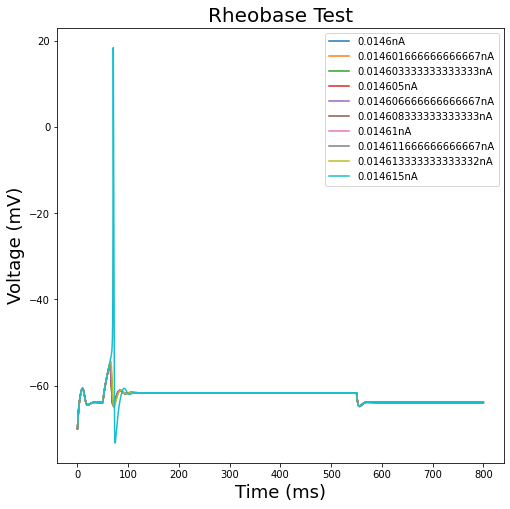

In [13]:
# Inject a current step into the soma
soma = create_cell(120, 1.6, 0.1, 0.015)

stim, rec_v, rec_t = simulation_protocol(soma)

# Apply stimulation protocol with different current to get Rheobase (min current)
compute_rheobase(rec_v, rec_t, 0.0146, 0.014615, 10, stim)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier ins

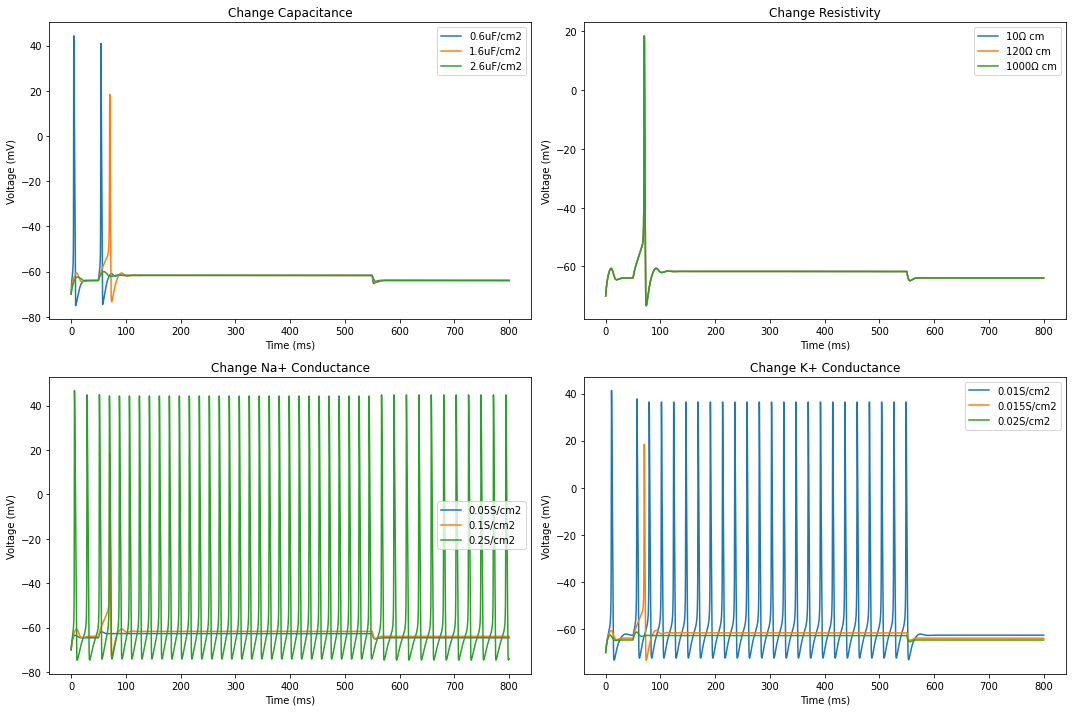

In [20]:
C = [0.6, 1.6, 2.6]
Ra = [10, 120, 1000]
gna = [0.05, 0.1, 0.2]
gk = [0.01, 0.015, 0.02]

fig = plt.figure(figsize=(15, 10))

for cm in C:
    soma = create_cell(120, cm, 0.1, 0.015)
    stim, rec_v, rec_t = simulation_protocol(soma)
    stim.amp = 0.014615
    h.load_file('stdrun.hoc')
    h.finitialize(-70)
    h.continuerun(800)
    
    axes = fig.add_subplot(2, 2, 1)
    axes.plot(rec_t, rec_v, label=str(cm) + 'uF/cm2')
    axes.set_title('Change Capacitance')
axes.legend()
axes.set_xlabel('Time (ms)')
axes.set_ylabel('Voltage (mV)')

for ra in Ra:
    soma = create_cell(ra, 1.6, 0.1, 0.015)
    stim, rec_v, rec_t = simulation_protocol(soma)
    stim.amp = 0.014615
    h.load_file('stdrun.hoc')
    h.finitialize(-70)
    h.continuerun(800)
    
    axes = fig.add_subplot(2, 2, 2)
    axes.plot(rec_t, rec_v, label=str(ra) + '\u03A9 cm')
    axes.set_title('Change Resistivity')
axes.legend()
axes.set_xlabel('Time (ms)')
axes.set_ylabel('Voltage (mV)')

for na in gna:
    soma = create_cell(120, 1.6, na, 0.015)
    stim, rec_v, rec_t = simulation_protocol(soma)
    stim.amp = 0.014615
    h.load_file('stdrun.hoc')
    h.finitialize(-70)
    h.continuerun(800)
    
    axes = fig.add_subplot(2, 2, 3)
    axes.plot(rec_t, rec_v, label=str(na) + 'S/cm2')
    axes.set_title('Change Na+ Conductance')
axes.legend()
axes.set_xlabel('Time (ms)')
axes.set_ylabel('Voltage (mV)')

for k in gk:
    soma = create_cell(120, 1.6, 0.1, k)
    stim, rec_v, rec_t = simulation_protocol(soma)
    stim.amp = 0.014615
    h.load_file('stdrun.hoc')
    h.finitialize(-70)
    h.continuerun(800)
    
    axes = fig.add_subplot(2, 2, 4)
    axes.plot(rec_t, rec_v, label=str(k) + 'S/cm2')
    axes.set_title('Change K+ Conductance')
axes.legend()
axes.set_xlabel('Time (ms)')
axes.set_ylabel('Voltage (mV)')

fig.tight_layout()

Find the minimum amount of current that has to be injected in this cell in order to make it fire (an automated way of finding this value is an option). What is the threshold membrane voltage? How do the rheobase and theshold voltage change when the membrane properties are changed?

    - Capacitance
    - Axial Resistance
    - Na Conductance
    - K Conductance

#### Changing Capacitance:

We used different values of capacitances from 0.6 to 2.6 uF. Consequently, decreasing the cell's capacitance would lead to decreasing Rheobase and Voltage thrshold (which means that the cell could easily fire with lower current values). This is because lower capacitance values will charge up quickly

#### Changing Resistance:
We used several values of Resistance but no big changes were observed.

#### Changing Na Conductance:
By increasing the Na conductance, the cell would fire with lower current values due to making electrical charges move easily through a membrane leading to cell depolarization at lower voltage threshold" and by decreasing the conductance it will increase the Rheobase and the voltage threshold.

#### Changing K Conductance:
By increasing the K conductance, the cell would fire with higher current values due to making potassium electrical charges move easily outside a membrane leading to a difficult cell depolarization at lower voltage threshold which means we need more current to cause firing.

# Ex4. Modifing K+ channel kinetics

<font size = "3">Create a cell in Neuron with the following characteristics: 1 section (soma) with one segment, 17.0 µm of length and diameter, 122 Ω*cm of axial radious and 1.2 µF/cm^2 of capacitance. Add passive and active (gNa = 0.09 S and gK = 0.01 S) membrane properties to this cell. Generate a current clamp experiment in which you will inject a current into the cell soma with 150 ms delay, 600 ms of duration. The total recording duration of the experiment would be 1000 ms and the voltage base -70 mV. 

<font size = "3">Increase and decrease the v_half parameter on the mod file with the K+ channel kinetics. Plot the resulting voltage curves and the I-V and tau-V curves. 

<font size = "3">Explain what is going on. What is the meaning of v_half? Why does changing this parameter affect the resultant action potential? [2.5 pts]

In [14]:
# Compiling the mechanisms inside the MOD files (and creating a new folder x86_64/special).
! nrnivmodl

Creating x86_64 directory for .o files.

/home/In Silico/Week 3
K_Channel.mod K_Channel_change_Tau.mod K_Channel_change_mInf.mod Na_Channel.mod
K_Channel.mod K_Channel_change_Tau.mod K_Channel_change_mInf.mod Na_Channel.mod
"/usr/local/nrn/x86_64/bin/nocmodl" K_Channel
"/usr/local/nrn/x86_64/bin/nocmodl" K_Channel_change_Tau
"/usr/local/nrn/x86_64/bin/nocmodl" K_Channel_change_mInf
"/usr/local/nrn/x86_64/bin/nocmodl" Na_Channel
Translating K_Channel_change_Tau.mod into K_Channel_change_Tau.c
Translating Na_Channel.mod into Na_Channel.c
Translating K_Channel_change_mInf.mod into K_Channel_change_mInf.c
Translating K_Channel.mod into K_Channel.c
Thread Safe
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o K_Channel_change_Tau.lo K_Channel_change_Tau.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c K_Chan

In [15]:
# Create a section 
soma = h.Section()
soma.L = 17.0     # length (µm)
soma.diam = 15.0  # diameter (µm)
soma.Ra = 122.0   # axial resistivity (Ω*cm)
soma.cm = 1.2       # capacitance (µF/cm^2) 

# Insert passive properties
soma.insert('pas')
for seg in soma:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70   # Leak reversal potential, it influences the steady state membrane potential

# Insert active properties
# Using HH model
soma.insert('hh')
for seg in soma:
    seg.hh.gkbar = 0.01 # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.09  # Maximal conductance of the sodium channels

# Using the mod files
# soma.insert('K_Ch_mInf') ######## This channel dynamic desciption is in K_channel_change_mInf.mod
# for seg in soma:
#     seg.gKv3bar_K_Ch_mInf = 0.01   # Maximal conductance of the potassium channels

# soma.insert('Na_Ch')
# for seg in soma:
#     seg.gNa_Sbar_Na_Ch = 0.09   # Maximal conductance of the sodium channels

In [16]:
# Inject a current step into the soma
stim = h.IClamp(soma(0.5))         # Place a stimulation electrode in the middle of the soma
stim.delay = 150   # stim delay (ms)
stim.dur = 600     # stim duration (ms)

# Initialize NEURON vectors to record time, voltage and current
# time vector
rec_t = h.Vector()
rec_t.record(h._ref_t)

# membrame potential vector
rec_v = h.Vector()
rec_v.record(soma(0.5)._ref_v)

# Na current
rec_iNa = h.Vector()
rec_iNa.record(soma(0.5)._ref_ina)
# K current
rec_iK = h.Vector()
rec_iK.record(soma(0.5)._ref_ik)

# Initialize and run a simulation
h.finitialize(-70)    # initial voltage 
h.continuerun(1000)    # total recording duration

0.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


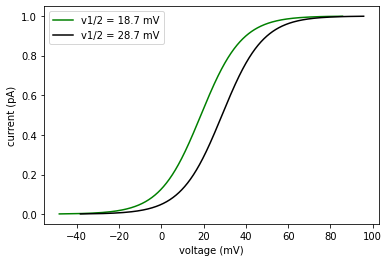

In [17]:
# v_half = 18.7 mV
I1 = np.arange(0, 1.0, 0.001)
V1 = []
for i1 in I1:
    v1 = 18.7 - 9.7*np.log((1/i1)-1)
    V1.append(v1)

# v_half = 28.7 mV
I2 = np.arange(0, 1.0, 0.001)
V2 = []
for i2 in I2:
    v2 = 28.7 - 9.7*np.log((1/i2)-1)
    V2.append(v2)

plt.figure()
plt.xlabel('voltage (mV)')
plt.ylabel('current (pA)')
plt.plot(V1, I1, 'g', label='v1/2 = 18.7 mV')
plt.plot(V2, I2, 'k',label='v1/2 = 28.7 mV')
plt.legend()